In [182]:
from functools import reduce
from collections import namedtuple

import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import scipy
import pandas as pd

In [174]:
num_stairs = 10
num_examples = 10
adv_eps = (1.0 / 3)
noise_eps = 0.1
x_noise = 0.1
slope = 1
#theta = np.random.randn(feats.shape[1])
lamda = 0.01
np.set_printoptions(precision=5)

knots = np.r_[np.arange(num_stairs), np.arange(num_stairs)-adv_eps, np.arange(num_stairs)+adv_eps]
knots = np.sort(knots)

# weights on different stairs
weights_1 = np.asarray([1/5]*5)
weights_2 = np.asarray([0.01]*(num_stairs-5))
weights = np.concatenate([weights_1, weights_2])
weights /= np.sum(weights)

Result = namedtuple('Result', ['x'])

In [82]:
def generate_x_noise(n):    
    # with probability x_noise there is noise
    unit_noise = (np.random.rand(n) < 0.5).astype(float)
    noise_mask = (np.random.rand(n) < x_noise).astype(float)
    return noise_mask * (unit_noise*2 - 1)*adv_eps

def data_gen(n, weights):
    num_stairs = len(weights)
    # sample from categorical distribution
    X = np.random.choice(num_stairs, p=weights, size=n).astype(float)
    return X

def label_noise(n, eps):
    return eps * np.random.randn(n)

def get_test_set():
    num_samples_per_stair = 10000
    # X_test has every row a different class and columns are samples from that class
    y_test = slope*np.arange(num_stairs).astype(float)[:, np.newaxis] * np.ones((num_stairs, num_samples_per_stair))
    X_test = np.arange(num_stairs).astype(float)[:, np.newaxis]
    noise = (np.random.rand(num_stairs, num_samples_per_stair)*2 - 1)*adv_eps
    X_test = X_test + noise
    return X_test, y_test

def get_feats(X, knots):
    X = X[:, np.newaxis]
    M = 4
    aug = np.arange(1, M+1)
    knots = np.r_[aug - M - 1 - knots[0], knots, aug + knots[-1]]

    K = len(knots)
    bases = (X >= knots[:-1]).astype(np.int) * (X < knots[1:]).astype(np.int)
    # do recursion from Hastie et al. vectorized
    maxi = len(knots) - 1
    for m in range(2, M+1):
        maxi -= 1

        # left sub-basis
        num = (X - knots[:maxi])* bases[:, :maxi]
        denom = knots[m-1 : maxi+m-1] - knots[:maxi]
        left = num/denom

        # right sub-basis
        num = (knots[m : maxi+m] - X) * bases[:, 1:maxi+1]
        denom = knots[m:maxi+m] - knots[1 : maxi+1]
        right = num/denom

        bases = left + right
    return bases


In [83]:
def sqerr(feats, y, theta): 
    return np.square(feats.dot(theta) - y).sum()

def sparse_diff(array, n=1, axis=-1):                                                                                                                 
    if (n < 0) or (int(n) != n):                                                
        raise ValueError('Expected order is non-negative integer, '             
                         'but found: {}'.format(n))                             
    if not scipy.sparse.issparse(array):                                        
        warnings.warn('Array is not sparse. Consider using numpy.diff')         
                                                                                
    if n == 0:                                                                  
        return array                                                            
                                                                                
    nd = array.ndim                                                             
    slice1 = [slice(None)]*nd                                                   
    slice2 = [slice(None)]*nd                                                   
    slice1[axis] = slice(1, None)                                               
    slice2[axis] = slice(None, -1)                                              
    slice1 = tuple(slice1)                                                      
    slice2 = tuple(slice2)                                                      
                                                                                
    A = sparse_diff(array, n-1, axis=axis)                                      
    return A[slice1] - A[slice2]  

def derivative(n, order=2):                                                     
    if n == 1:                                                                  
        # no derivative for constant functions                                  
        return scipy.sparse.csc_matrix(0.)                                      
    D = sparse_diff(scipy.sparse.identity(n).tocsc(), n=order).tolil()          
    return np.asarray(D.dot(D.T).tocsc().todense()) 

def get_P(knots, with_intercept=False):
    P = derivative(len(knots) + 4, order=2) 
    return P

def norm(theta):
    return P.dot(theta).dot(theta)

def T(x):
    x_round = np.round(x)
    return [x_round-adv_eps, x_round,  x_round+adv_eps]
    
def sqerr_adv(theta, T_feats):
    sqerrs = [np.square(dat.dot(theta) - y) for dat in T_feats]
    max_errs = np.sum(np.maximum.reduce(sqerrs))
    return max_errs

def test_sqerr(X_test, theta): 
    def err_y_for_x(x, e_y):                                                    
        x_feats = get_feats(np.asarray([x]), knots)                             
        preds_x = x_feats.dot(theta)[0]                                         
        err_for_pt = np.square(preds_x) - 2*preds_x*e_y + noise_eps**2 + np.square(e_y)
        return err_for_pt                                                       
                                                                                
    total_err = []                                                              
    for i in range(X_test.shape[0]):                                                                                                            
        class_i_err = 0                                                     
        for x in [i-adv_eps, i+adv_eps]:                                    
            class_i_err += 0.5 * x_noise * err_y_for_x(x, slope*i)                                                                
        class_i_err += (1-x_noise)*err_y_for_x(i, slope*i)                      
        total_err.append(class_i_err)                                           
    total_err = np.asarray(total_err)                                           
    return np.sum(total_err * weights)

def summarize(theta, X, y, X_test):
    T_feats = [get_feats(xx, knots) for xx in [X, X-adv_eps, X+adv_eps]]
    feats = np.array(T_feats[0])
    print("sq err train")
    print(sqerr(feats, y, theta)/X.shape[0])
    print("sq err adv train")
    print(sqerr_adv(theta, T_feats)/X.shape[0])
    print("sq err test")
    print(test_sqerr(X_test, theta))
    print("generalization gap")
    print(test_sqerr(X_test, theta) - sqerr(feats[0], y, theta)/X.shape[0])
    print("rkhs norm")
    print(norm(theta))

In [84]:
def solve_normal(f_mat, labels, l):
    mat = f_mat.T.dot(f_mat) + l * get_P(knots)
    theta = np.linalg.pinv(mat).dot(f_mat.T.dot(labels))
    res_normal = Result(x=theta)
    return res_normal

def solve_adv(T_feats, y, lamda, P):
    theta_var = cp.Variable(T_feats[0].shape[1])
    sum_sq = [cp.square(dat*theta_var - y) for dat in T_feats]
    objective = cp.Minimize(cp.sum(reduce(cp.maximum, sum_sq)) + lamda*cp.quad_form(theta_var, P))
    prob = cp.Problem(objective)
    prob.solve()
    return Result(x=theta_var.value)

def solve_trades(T_feats, y, lamda, P, beta):
    theta_var = cp.Variable(T_feats[0].shape[1])
    mse = cp.square(T_feats[1]*theta_var - y)
    sum_sq = [cp.square(dat*theta_var - T_feats[1]*theta_var) for dat in T_feats]
    objective = cp.Minimize(cp.sum(mse) + beta * cp.sum(reduce(cp.maximum, sum_sq)) + lamda*cp.quad_form(theta_var, P))
    prob = cp.Problem(objective)
    prob.solve()
    return Result(x=theta_var.value)

In [85]:
P = get_P(knots)

In [188]:
def calc_mse_err(theta, X, y):
    feats = get_feats(X, knots)
    #feats = np.array([get_feats(x, knots) for x in X])
    mse = (np.dot(feats, theta) - y)**2
    return mse.mean()

def adv_mse_err(theta, X, y):
    preds = np.array([np.dot(get_feats(x, knots), theta) for x in [X-adv_eps, X, X+adv_eps]])
    mse = ((preds - y)**2).max(0)
    return mse.mean()

def get_sol(trnX, trny, tstX, tsty, prob, beta=1, cv="nor"):
    feats = get_feats(trnX, knots)
    T_feats = [get_feats(xx, knots) for xx in [trnX-adv_eps, trnX, trnX+adv_eps]]
    #tst_feats = get_feats(tstX, knots)
    
    lamdas = [1e2, 1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4]
    #lamdas = [1e-1]
    mse_err = []
    adv_err = []
    rets = []
    
    for lamda in lamdas:
        if prob == "normal":
            res = solve_normal(feats, trny, lamda)
        elif prob == "adv":
            res = solve_adv(T_feats, trny, lamda, P)
        elif prob == "trades":
            res = solve_trades(T_feats, trny, lamda, P, beta=beta)
        theta = res.x
        adv_err.append(adv_mse_err(theta, trnX, trny))
        mse_err.append(calc_mse_err(theta, tstX, tsty))
        rets.append(theta)

    print(mse_err)
    if cv == "nor":
        return rets[np.argmin(mse_err)]
    else:
        return rets[np.argmin(adv_err)]

def print_results(theta, trnX, trny, tstX, tsty):
    trn_mse = calc_mse_err(theta, trnX, trny)
    tst_mse = calc_mse_err(theta, tstX, tsty)
    adv_trn_mse = adv_mse_err(theta, trnX, trny)
    adv_tst_mse = adv_mse_err(theta, tstX, tsty)
    
    #print(f"trn mse: {trn_mse}")
    #print(f"advtrn mse: {adv_trn_mse}")
    
    #print(f"tst mse: {tst_mse}")
    #print(f"advtst mse: {adv_tst_mse}")
    
    #print(f"gap: {-trn_mse + tst_mse}")
    #print(f"adv gap: {-adv_trn_mse + adv_tst_mse}")
    return trn_mse, tst_mse, adv_trn_mse, adv_tst_mse


(10, 34)
[0.023821157362419753, 0.02358281392778658, 0.025327867501791813, 0.05059147619224643, 0.10579080657627662, 0.12057987597043981, 0.12229012275811574]
[0.022483547269342256, 0.02292538079408092, 0.053764744354825277, 0.17168728020555474, 0.17972093971861544, 0.12814755683753307, 0.11833024449787848]
[0.029015013680423196, 0.029835056114823413, 0.04684709860355829, 0.1557805547985108, 0.1646830516078525, 0.05035210384921496, 0.038536029107061505]
[0.025329766742835113, 0.02531178148633898, 0.03419218247705207, 0.11181543810559454, 0.20807252617551814, 0.07893006103462807, 0.058427487529834544]


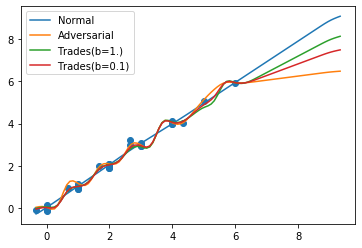

In [191]:
num_examples = 40
np.random.seed(1)
trnX = data_gen(num_examples, weights)
trny = slope*trnX + label_noise(trnX.shape[0], noise_eps)
trnX += generate_x_noise(num_examples)

tstX = data_gen(10000, weights)
tsty = slope*tstX + label_noise(tstX.shape[0], noise_eps)
tstX += generate_x_noise(10000)

X_test, y_test = get_test_set()

feats = get_feats(X, knots)
print(feats.shape)

theta_normal = get_sol(trnX, trny, tstX, tsty, "normal", cv="nor")
theta_adv = get_sol(trnX, trny, tstX, tsty, "adv", cv="adv")
theta_trd_1 = get_sol(trnX, trny, tstX, tsty, "trades", beta=1, cv="adv")
theta_trd_0 = get_sol(trnX, trny, tstX, tsty, "trades", beta=0.5, cv="adv")


X_plot = np.linspace(-adv_eps, num_stairs-1 + adv_eps, 100)
feats_plot = get_feats(X_plot, knots)
normal_plot_preds = feats_plot.dot(theta_normal)

#plt.scatter(X_test, y_test)
plt.scatter(trnX, trny)
plt.plot(X_plot, normal_plot_preds, label="Normal")
adv_plot_preds = feats_plot.dot(theta_adv)
plt.plot(X_plot, adv_plot_preds, label="Adversarial")
trd_plot_preds = feats_plot.dot(theta_trd_1)
plt.plot(X_plot, trd_plot_preds, label="Trades(b=1.)")
trd_plot_preds = feats_plot.dot(theta_trd_0)
plt.plot(X_plot, trd_plot_preds, label="Trades(b=0.1)")
plt.legend()
plt.savefig("./temp.png")
#print("Normal")
normal_res = print_results(theta_normal, trnX, trny, tstX, tsty)
#print(test_sqerr(X_test, theta_normal))
#summarize(theta_normal, X, y, X_test)
#print()
#print("Adversarial")
adv_res = print_results(theta_adv, trnX, trny, tstX, tsty)
#print(test_sqerr(X_test, theta_adv))
#summarize(theta_adv, X, y, X_test)
#print()
#print("Trades(1.)")
trd1_res = print_results(theta_trd_1, trnX, trny, tstX, tsty)
#print(test_sqerr(X_test, theta_trd_1))
#summarize(theta_trd_1, X, y, X_test)
#print()
#print("Trades(.1)")
trd0_res = print_results(theta_trd_0, trnX, trny, tstX, tsty)
#print(test_sqerr(X_test, theta_trd_0))
#summarize(theta_trd_0, X, y, X_test)
df = pd.DataFrame.from_dict({
    "normal": normal_res,
    "AT": adv_res,
    "Trades(1.)": trd1_res,
    "Trades(.1)": trd0_res,
}, orient="index")
df.columns = ['tr MSE', 'ts MSE', 'adv tr MSE', 'adv ts MSE']

In [195]:
print(df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &    tr MSE &    ts MSE &  adv tr MSE &  adv ts MSE \\
\midrule
normal     &  0.020196 &  0.023583 &    0.195853 &    0.204245 \\
AT         &  0.013115 &  0.118330 &    0.107656 &    0.213164 \\
Trades(1.) &  0.016801 &  0.038536 &    0.121630 &    0.154097 \\
Trades(.1) &  0.011025 &  0.058427 &    0.118336 &    0.170809 \\
\bottomrule
\end{tabular}



(10, 34)
[0.018309759844976257, 0.013613288881799877, 0.010487326095720114, 0.009999005025456021, 0.009961844325998026, 0.009964154822851493, 0.009964535590789214]
[0.014683951786379615, 0.012178177284948176, 0.01166757782657317, 0.011742985892351848, 0.011742619841563476, 0.011741347419647004, 0.011737817029893233]
[0.018752556306048974, 0.014724065672766403, 0.014051264702963483, 0.014012795800528097, 0.014011017461711257, 0.014010871099003676, 0.014010856791470135]
[0.017351560660815623, 0.013270947775195836, 0.012268326781629894, 0.012134313345278383, 0.012122694322755926, 0.012121552287165835, 0.012121438321683676]


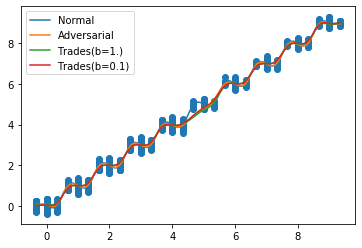

In [196]:
num_examples = 25000
np.random.seed(1)
trnX = data_gen(num_examples, weights)
trny = slope*trnX + label_noise(trnX.shape[0], noise_eps)
trnX += generate_x_noise(num_examples)

tstX = data_gen(15000, weights)
tsty = slope*tstX + label_noise(tstX.shape[0], noise_eps)
tstX += generate_x_noise(15000)

feats = get_feats(X, knots)
print(feats.shape)

theta_normal = get_sol(trnX, trny, tstX, tsty, "normal", cv="nor")
theta_adv = get_sol(trnX, trny, tstX, tsty, "adv", cv="adv")
theta_trd_1 = get_sol(trnX, trny, tstX, tsty, "trades", beta=1, cv="adv")
theta_trd_0 = get_sol(trnX, trny, tstX, tsty, "trades", beta=0.5, cv="adv")


X_plot = np.linspace(-adv_eps, num_stairs-1 + adv_eps, 100)
feats_plot = get_feats(X_plot, knots)
normal_plot_preds = feats_plot.dot(theta_normal)

#plt.scatter(X_test, y_test)
plt.scatter(trnX, trny)
plt.plot(X_plot, normal_plot_preds, label="Normal")
adv_plot_preds = feats_plot.dot(theta_adv)
plt.plot(X_plot, adv_plot_preds, label="Adversarial")
trd_plot_preds = feats_plot.dot(theta_trd_1)
plt.plot(X_plot, trd_plot_preds, label="Trades(b=1.)")
trd_plot_preds = feats_plot.dot(theta_trd_0)
plt.plot(X_plot, trd_plot_preds, label="Trades(b=0.1)")
plt.legend()
plt.savefig("./temp.png")
normal_res = print_results(theta_normal, trnX, trny, tstX, tsty)
adv_res = print_results(theta_adv, trnX, trny, tstX, tsty)
trd1_res = print_results(theta_trd_1, trnX, trny, tstX, tsty)
trd0_res = print_results(theta_trd_0, trnX, trny, tstX, tsty)
df = pd.DataFrame.from_dict({
    "normal": normal_res,
    "AT": adv_res,
    "Trades(1.)": trd1_res,
    "Trades(.1)": trd0_res,
}, orient="index")
df.columns = ['tr MSE', 'ts MSE', 'adv tr MSE', 'adv ts MSE']

In [26]:
num_examples = 10000
X = data_gen(num_examples, weights)
y = slope*X + label_noise(X.shape[0], noise_eps)
X += generate_x_noise(num_examples)

X_test, y_test = get_test_set()
    
feats = get_feats(X, knots)
print(feats.shape)
res_normal = solve_normal(feats, y, lamda)

# adversarial training data
T_feats = [get_feats(xx, knots) for xx in [X-adv_eps, X, X+adv_eps]]

res_adv = solve_adv(T_feats, y, lamda, P)
res_trd = solve_trades(T_feats_aug, y_aug, lamda, P, beta=1)

X_plot = np.linspace(-adv_eps, num_stairs-1 + adv_eps, 100)
feats_plot = get_feats(X_plot, knots)
normal_plot_preds = feats_plot.dot(res_normal.x)

plt.scatter(X, y)
plt.plot(X_plot, normal_plot_preds, label="Normal")
adv_plot_preds = feats_plot.dot(res_adv.x)
plt.plot(X_plot, adv_plot_preds, label="Adversarial")
trd_plot_preds = feats_plot.dot(res_trd.x)
plt.plot(X_plot, trd_plot_preds, label="Trades")
plt.legend()
print("Normal")
summarize(res_normal, X)
print()
print("Adversarial")
summarize(res_adv, X)
print()
print("Trades")
summarize(res_trd, X)

(10000, 34)


SolverError: Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.